# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

batch_size = 35

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
#sample x y z invocations
# x = 30 # No. of frames images
# y = 100 # Width of the image
# z = 100 # height

def generator(source_path, folder_list, batch_size,x,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[i for i in range(0, x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (y, z))  # Resizing to (y,z,3)
                    
                    batch_data[folder,idx,:,:,0] =  image[:, :, 0] / 255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =  image[:, :, 1] / 255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =  image[:, :, 2] / 255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list) % batch_size != 0:
            remaining_folders = folder_list[num_batches * batch_size:]
            batch_size_remaining = len(remaining_folders)

            batch_data = np.zeros((batch_size_remaining,x,y,z,3))
            batch_labels = np.zeros((batch_size_remaining, 5))

            for folder in range(batch_size_remaining):
                folder_name = remaining_folders[folder].split(';')[0]
                imgs = os.listdir(source_path + '/' + folder_name)

                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + folder_name + '/' + imgs[item]).astype(np.float32)
                    image = resize(image, (y, z))

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255.0
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255.0
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255.0

                batch_labels[folder, int(remaining_folders[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
# train_path = '/kaggle/working/Project_data/train'
# val_path = '/kaggle/working/Project_data/val'
train_path = '/home/datasets/Project_data/train' ##From Jarvis, same below
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 ## default initiali take 15 only
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [6]:
# define function for plotting
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here we made the model using different functionalities that Keras provides: Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

####  Model1: 100x100 image with CNN3D

In [7]:
#Import keras packages

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
x=30
y=100
z=100
#Model
model_1 = Sequential()       
model_1.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, y, z, 3),padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(Conv3D(16, (3, 3, 3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(32, (2, 2, 2), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(64, (2, 2, 2), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_1.add(Conv3D(128, (2, 2, 2), padding='same'))
model_1.add(Activation('relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_1.add(Flatten())

model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))

#Softmax layer

model_1.add(Dense(5, activation='softmax'))

2025-03-04 18:09:48.886789: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-04 18:09:48.886849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
from tensorflow.keras.optimizers import Adam
optimiser = Adam(learning_rate=0.01)#write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 100, 100, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 100, 100, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 100, 100, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 100, 100, 16)  3472      
                                                                 
 activation_1 (Activation)   (None, 30, 100, 100, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 100, 100, 16)  64       
 hNormalization)                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [66]:
#Commenting this code as this model has some issues
##history1=model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                  ##  callbacks=callbacks_list, validation_data=val_generator, 
                 ##   validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15


InvalidArgumentError:  Input to reshape is a tensor with 163840 values, but the requested shape requires a multiple of 4608
	 [[node sequential/flatten/Reshape
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/core/flatten.py:96)
]] [Op:__inference_train_function_1909]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/flatten/Reshape:
In[0] sequential/max_pooling3d_3/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[1] sequential/flatten/Const (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/core/flatten.py:91)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_203/3558631649.py", line 1, in <module>
>>>     history1=model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/flatten.py", line 96, in call
>>>     return tf.reshape(inputs, flattened_shape)
>>> 

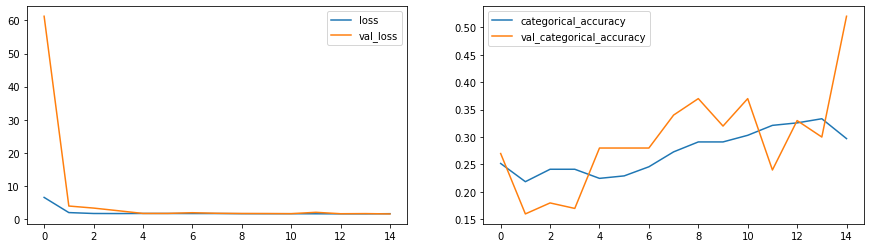

In [14]:
##plot(history1)

### Model2: 160x160 image with CNN3D

In [15]:
x=30
y=160
z=160
#write your model here
model_2 = Sequential()       
model_2.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, y, z, 3),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(Conv3D(16, (3, 3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(32, (2, 2, 2), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(64, (2, 2, 2), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(128, (2, 2, 2), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_2.add(Flatten())

model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.5))

#Softmax layer

model_2.add(Dense(5, activation='softmax'))

In [16]:
from tensorflow.keras.optimizers import Adam
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 160, 160, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 160, 160, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 30, 160, 160, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 160, 160, 16)  3472      
                                                                 
 activation_6 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 160, 160, 16)  64       
 hNormalization)                                      

In [17]:
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [18]:
history2=model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0,workers=1)

Source path =  /home/datasets/Project_data/train ; batch size = 35
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 4.4447 - categorical_accuracy: 0.2760Source path =  /home/datasets/Project_data/val ; batch size = 35

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-4.44474-0.27602-2.43505-0.20000.keras
19/19 [==============================] - 182s 10s/step - loss: 4.4447 - categorical_accuracy: 0.2760 - val_loss: 2.4351 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.6090 - categorical_accuracy: 0.2413
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-1.60897-0.24133-4.86126-0.14000.keras
19/19 [==============================] - 175s 10s/step - loss: 1.6090 - categorical_accuracy: 0.2413 - val_loss: 4.8613 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.6079 - categorical

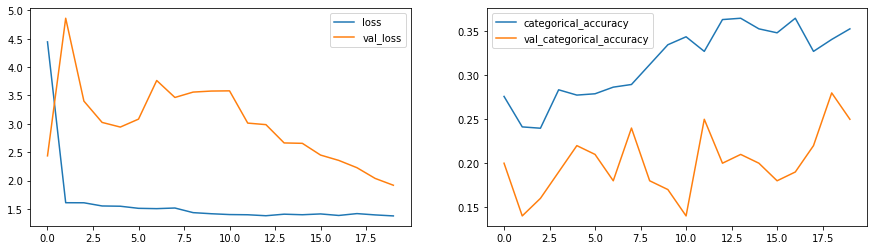

In [20]:
plot(history2)

### Model3: with 160X160 and batch size 60 (using model2 and new batch size)

In [21]:
batch_size = 60
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [22]:
# as this will fail with OOM error commeting below code to run the subsequent cells

# history3=model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, initial_epoch=0)

### Model4: different set of Conv3d filter and Dense layer

In [23]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts and batch normalisation

model_4 = Sequential()       
model_4.add(Conv3D(8,kernel_size=(2,2,2),input_shape=(x,y,z,3),padding='same'))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))

model_4.add(Conv3D(16, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(32, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(64, (2, 2, 2), padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer 

model_4.add(Flatten())

model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.2))

model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))

#Softmax layer

model_4.add(Dense(5, activation='softmax'))

In [24]:
optimiser = Adam(learning_rate=0.01)#write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 8)   200       
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_11 (Conv3D)          (None, 30, 120, 120, 16)  1040      
                                                                 
 activation_11 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [25]:
batch_size = 15
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [26]:
history4=model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 87.2032 - categorical_accuracy: 0.2947Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-87.20319-0.29474-319.22449-0.22222.keras
19/19 [==============================] - 66s 4s/step - loss: 87.2032 - categorical_accuracy: 0.2947 - val_loss: 319.2245 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 14.8121 - categorical_accuracy: 0.4211
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-14.81207-0.42105-246.71562-0.22500.keras
19/19 [==============================] - 67s 4s/step - loss: 14.8121 - categorical_accuracy: 0.4211 - val_loss: 246.7156 - val_categorical_accuracy: 0.2250 - lr: 0.0100
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 5.5111 - c

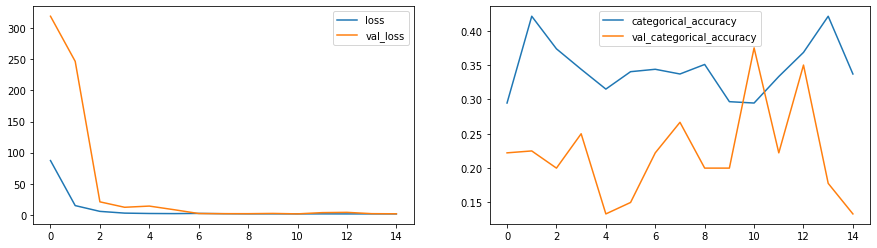

In [27]:
plot(history4)

### Model5: CNN + LSTM

In [28]:
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras import optimizers


x = 30 # number of frames
y = 120 # image width
z = 120 # image height

model_5 = Sequential()
model_5.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=(x,y,z,3)))
model_5.add(BatchNormalization())
model_5.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model_5.add(BatchNormalization())
model_5.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model_5.add(BatchNormalization())
model_5.add(TimeDistributed(Dense(64, activation='relu')))
model_5.add(BatchNormalization())
model_5.add(GlobalAveragePooling2D())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(5, activation='softmax'))

In [29]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization_14 (Bat  (None, 30, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_15 (Bat  (None, 30, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [30]:
batch_size = 15
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [31]:
history5=model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0,workers=1)

Source path =  /home/datasets/Project_data/train ; batch size = 15
Epoch 1/15
19/19 [==============================] - ETA: 0s - loss: 1.5017 - categorical_accuracy: 0.3333Source path =  /home/datasets/Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-1.50170-0.33333-1.59238-0.24444.keras
19/19 [==============================] - 71s 4s/step - loss: 1.5017 - categorical_accuracy: 0.3333 - val_loss: 1.5924 - val_categorical_accuracy: 0.2444 - lr: 0.0010
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 1.3974 - categorical_accuracy: 0.4035
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-1.39744-0.40351-1.59866-0.12500.keras
19/19 [==============================] - 62s 3s/step - loss: 1.3974 - categorical_accuracy: 0.4035 - val_loss: 1.5987 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 1.3416 - categorical_acc

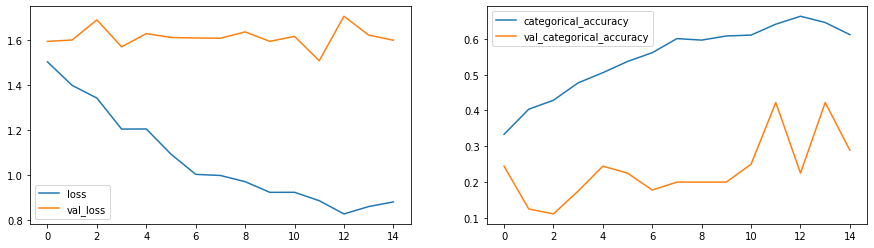

In [32]:
plot(history5)

### Model6: TimeDistributed Conv2D + GRU

In [33]:
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
model_6 = Sequential()
model_6.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(x,y,z,3)))
model_6.add(TimeDistributed( MaxPooling2D((2,2))))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.2))

model_6.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model_6.add(TimeDistributed(MaxPooling2D((2,2))))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.2))

model_6.add(TimeDistributed(GlobalAveragePooling2D()))
model_6.add(TimeDistributed(Dense(64, activation='relu')))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.2))

model_6.add(GRU(128))
model_6.add(BatchNormalization())
model_6.add(Dense(5, activation='softmax'))

In [34]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 30, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 30, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 30, 59, 59, 32)    0         
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 57, 57, 64)   18496     
 tributed)                                            

In [35]:
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [ ]:
history6=model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
19/19 [==============================] - ETA: 0s - loss: 1.4517 - categorical_accuracy: 0.4368Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-1.45171-0.43684-1.59530-0.28333.keras
19/19 [==============================] - 90s 5s/step - loss: 1.4517 - categorical_accuracy: 0.4368 - val_loss: 1.5953 - val_categorical_accuracy: 0.2833 - lr: 0.0010
Epoch 2/25
19/19 [==============================] - ETA: 0s - loss: 1.2436 - categorical_accuracy: 0.4766
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-1.24361-0.47658-1.60187-0.23333.keras
19/19 [==============================] - 85s 5s/step - loss: 1.2436 - categorical_accuracy: 0.4766 - val_loss: 1.6019 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/25
19/19 [==============================] - ETA: 0s - loss: 1.0472 - categorical_acc

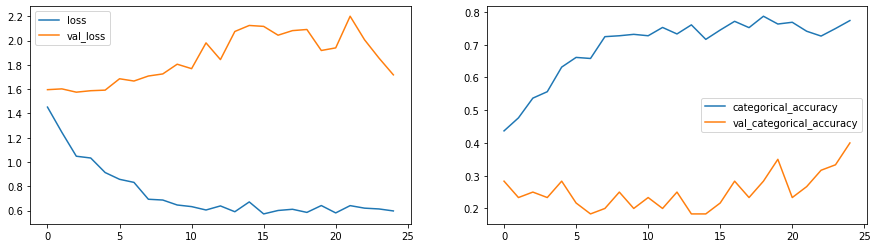

In [53]:
plot(history6)

### Model7: Different hyperparamter for CNN and dropout

In [54]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

model_7 = Sequential()
model_7.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(x,y,z,3)))
model_7.add(Activation('relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Conv3D(32, (3, 3, 3), padding='same'))
model_7.add(Activation('relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Conv3D(64, (2, 2, 2), padding='same'))
model_7.add(Activation('relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Conv3D(128, (2, 2, 2), padding='same'))
model_7.add(Activation('relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_7.add(Flatten())
model_7.add(Dense(64,activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.25))

model_7.add(Dense(64,activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.25))

model_7.add(Dense(5,activation='softmax'))

optimiser = Adam(learning_rate=0.002)
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_22 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_38 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_23 (Activation)  (None, 15, 60, 60, 32)   

In [55]:
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [56]:
history7=model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.5013 - categorical_accuracy: 0.4421Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-1.50125-0.44211-1.57189-0.25000.keras
19/19 [==============================] - 104s 6s/step - loss: 1.5013 - categorical_accuracy: 0.4421 - val_loss: 1.5719 - val_categorical_accuracy: 0.2500 - lr: 0.0020
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.1671 - categorical_accuracy: 0.5427
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-1.16709-0.54270-1.72606-0.26667.keras
19/19 [==============================] - 87s 5s/step - loss: 1.1671 - categorical_accuracy: 0.5427 - val_loss: 1.7261 - val_categorical_accuracy: 0.2667 - lr: 0.0020
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.0589 - categorical_ac

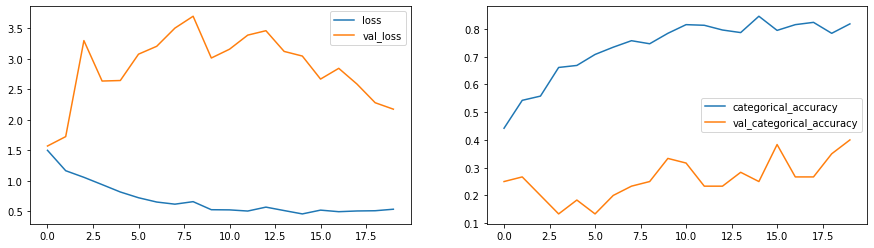

In [ ]:
plot(history7)

### Model8: 160x160 image

In [58]:
x = 30 # number of frames
y = 160 # image width
z = 160 # image height

model_8 = Sequential()
model_8.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(x,y,z,3)))
model_8.add(Activation('relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_8.add(Conv3D(32, (3, 3, 3), padding='same'))
model_8.add(Activation('relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_8.add(Conv3D(64, (2, 2, 2), padding='same'))
model_8.add(Activation('relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_8.add(Conv3D(128, (2, 2, 2), padding='same'))
model_8.add(Activation('relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_8.add(Flatten())
model_8.add(Dense(64,activation='relu'))
model_8.add(BatchNormalization())
model_8.add(Dropout(0.25))

model_8.add(Dense(64,activation='relu'))
model_8.add(BatchNormalization())
model_8.add(Dropout(0.25))

model_8.add(Dense(5,activation='softmax'))

optimiser = Adam(learning_rate=0.002)
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_26 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_44 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_27 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_27 (Activation)  (None, 15, 80, 80, 32)  

In [59]:
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [60]:
history8=model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.6361 - categorical_accuracy: 0.3921Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-1.63606-0.39211-2.05846-0.21667.keras
19/19 [==============================] - 104s 6s/step - loss: 1.6361 - categorical_accuracy: 0.3921 - val_loss: 2.0585 - val_categorical_accuracy: 0.2167 - lr: 0.0020
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.2691 - categorical_accuracy: 0.4986
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-1.26912-0.49862-1.64747-0.25000.keras
19/19 [==============================] - 99s 5s/step - loss: 1.2691 - categorical_accuracy: 0.4986 - val_loss: 1.6475 - val_categorical_accuracy: 0.2500 - lr: 0.0020
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.1984 - categorical_ac

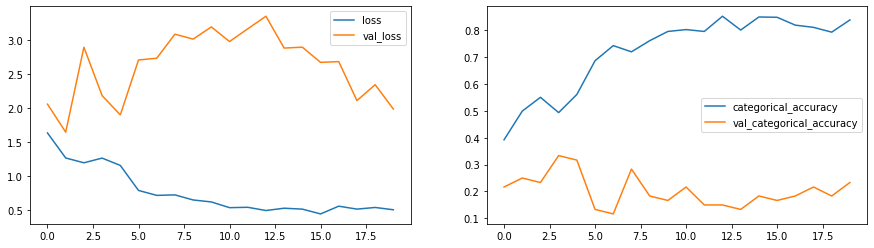

In [61]:
plot(history8)

### Model9: Transfer learning

In [62]:
from keras.applications import mobilenet
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
# from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Conv3D, ConvLSTM2D,MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam
x = 30 # number of frames
y = 128 # image width
z = 128 # image height
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False,input_shape=(y, z, 3))
model_9 = Sequential()
model_9.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))


model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))
model_9.add(TimeDistributed(Flatten()))

model_9.add(GRU(32))
model_9.add(Dropout(0.25))

model_9.add(Dense(32,activation='relu'))
model_9.add(Dropout(0.25))

model_9.add(Dense(5,activation='softmax'))


optimiser = Adam(learning_rate=0.002)
model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [63]:
history9=model_9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.5132 - categorical_accuracy: 0.3368Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2025-03-0418_09_45.365533/model-00001-1.51322-0.33684-1.82725-0.20000.keras
19/19 [==============================] - 102s 5s/step - loss: 1.5132 - categorical_accuracy: 0.3368 - val_loss: 1.8272 - val_categorical_accuracy: 0.2000 - lr: 0.0020
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.2973 - categorical_accuracy: 0.4160
Epoch 00002: saving model to model_init_2025-03-0418_09_45.365533/model-00002-1.29729-0.41598-1.34416-0.35000.keras
19/19 [==============================] - 91s 5s/step - loss: 1.2973 - categorical_accuracy: 0.4160 - val_loss: 1.3442 - val_categorical_accuracy: 0.3500 - lr: 0.0020
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.1465 - categorical_ac

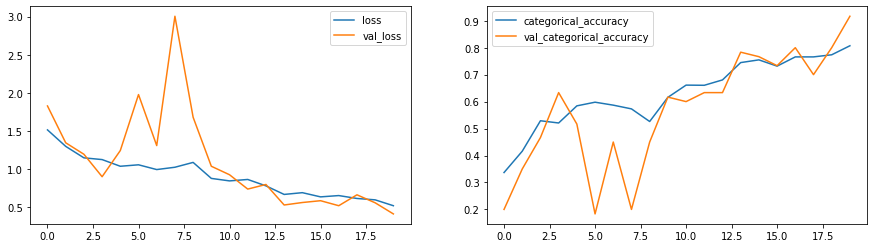

In [65]:
plot(history9)